In [0]:
import numpy as np
import statsmodels
import seaborn as sns

from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd


In [0]:
!pip install pa

  Running setup.py bdist_wheel for pa ... - \ done
  Stored in directory: /root/.cache/pip/wheels/6b/26/8a/3e0ae4378f4f8d59283df3460f395c25a25eb3a68feabb1187
Successfully built pa


In [0]:
import pa

**http://vincentarelbundock.github.io/Rdatasets/datasets.html**

In [0]:

data=pd.read_csv('Ginzberg.csv')
df = data[['adjdep', 'adjfatal', 'adjsimp']]
df

In [0]:
%%capture
#gather features
features = "+".join(df.columns)


In [0]:
# get y and X dataframes based on this regression:
y, X = dmatrices('adjdep ~' + features, df, return_type='dataframe')

**Step 2: Calculate VIF Factors**

In [0]:
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

In [0]:
vif.round(1)

,VIF Factor,features
0,6.7,Intercept
1,1.8,adjdep
2,1.7,adjfatal
3,1.6,adjsimp



**Conclusion : There is no multicolliniority  
 VIF <= 4 No multicolinority  and  whereas a value of >= 10 implies serious multicollinearity. **

**inear regression is simple, with statsmodels. We are able to use R style regression formula.**

In [0]:
import statsmodels.formula.api as smf
reg = smf.ols('adjdep ~ adjfatal + adjsimp', data=df).fit()


#dw_res = np.sum(np.diff(reg.resid.values))

In [0]:
dw_res

0.7221554079763797

In [0]:
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 adjdep   R-squared:                       0.433
Model:                            OLS   Adj. R-squared:                  0.419
Method:                 Least Squares   F-statistic:                     30.19
Date:                Wed, 09 Jan 2019   Prob (F-statistic):           1.82e-10
Time:                        09:20:45   Log-Likelihood:                -35.735
No. Observations:                  82   AIC:                             77.47
Df Residuals:                      79   BIC:                             84.69
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2492      0.105      2.365      0.021       0.039       0.459
adjfatal       0.3845      0.100      3.829      0.000       0.185       0.584
adjsimp        0.3663      0.100      3.649      0.000       0.166       0.566
==============================================================================
Omnibus:                       10.510   Durbin-Watson:                   1.178
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               10.561
Skew:                           0.836   Prob(JB):                      0.00509
Kurtosis:                       3.542   Cond. No.                         5.34
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [0]:
DW = np.sum( np.diff( result.resid.values )**2.0 ) / result.ssr
print 'Durbin-Watson: {:.5f}'.format( DW )

**Look for Durbin – Watson (DW) statistic. It must lie between 0 and 4. If DW = 2, implies no autocorrelation, 0 < DW < 2 implies positive autocorrelation while 2 < DW < 4 indicates negative autocorrelation. Also, you can see residual vs time plot and look for the seasonal or correlated pattern in residual values.**

**The presence of correlation in error terms drastically reduces model’s accuracy. This usually occurs in time series models where the next instant is dependent on previous instant.**

**Regression assumptions
**

**1.Linearity & Equal variance**

**Both can be tested by plotting residuals vs. predictions, where residuals are prediction errors.
**

In [0]:
pred_val = reg.fittedvalues.copy()

In [0]:
true_val = df['adjdep'].values.copy()

In [0]:
residual = true_val - pred_val

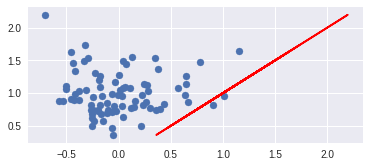

In [0]:
fig, ax = plt.subplots(figsize=(6,2.5))
_ = ax.scatter(residual, pred_val)
plt.plot(pred_val, pred_val, color='red')




**Cook's D Definition - Data points with large residuals (outliers) and/or high leverage may distort the outcome and accuracy of a regression. Cook's distance measures the effect of deleting a given observation. Points with a large Cook's distance are considered to merit closer examination in the analysis
:**

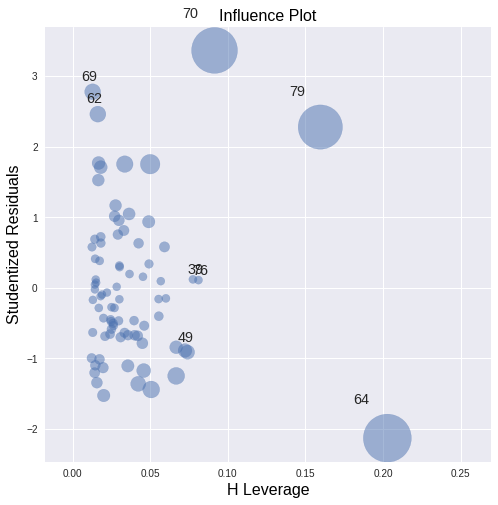

In [0]:
import scipy.stats as scipystats
import statsmodels.api as sm
import statsmodels.stats.stattools as stools
import statsmodels.stats as stats 
from statsmodels.graphics.regressionplots import *

fig, ax = plt.subplots(figsize=(8,8))
fig = sm.graphics.influence_plot(reg, ax = ax, criterion="cooks", plot_alpha=0.5)
plt.show()

**residuals versus predicted values If we speak as a layman, the errors (or residuals) should be close to zero (negitive or positive) for any predicted value. That said the dots should be close to horizantal line.**

**It seems like the corresponding residual plot is reasonably random. To confirm that, let’s go with a hypothesis test, Harvey-Collier multiplier test, for linearity**

In [0]:
import statsmodels.stats.api as sms
sms.linear_harvey_collier(reg)


/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Ttest_1sampResult(statistic=4.9902148829829125, pvalue=3.5816973971950396e-06)

**Several tests exist for equal variance, with different alternative hypotheses. Let’s go with Breusch-Pagan test as an example. More can be found here. Small p-value (pval below) shows that there is violation of homoscedasticity.**

In [0]:
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(residual, df[['adjfatal', 'adjsimp']])
pval, f_pval


(6.448482473014033e-08, 2.2130738396034907e-08)

**Usually assumption violations are not independent of each other. Having one violations may lead to another. In this case, we see that both linearity and homoscedasticity are not met**

**Normality
We can apply normal probability plot to assess how the data (error) depart from normality visually:**

0.9523990893322949

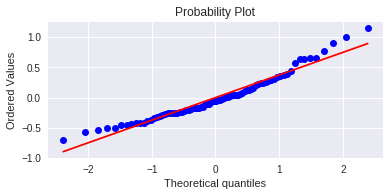

In [0]:
import scipy as sp
fig, ax = plt.subplots(figsize=(6,2.5))
_, (__, ___, r) = sp.stats.probplot(residual, plot=ax, fit=True)
r**2


**The good fit indicates that normality is a reasonable approximation**